In [1]:
import os, json, glob
import pandas as pd

import numpy as np
import pydicom
import scipy
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/users/jsoelter/Code/ChestImageAI/utils/')
import data_loader, evaluations #model_setup

In [3]:
datafolder = '/work/projects/covid19_dv/raw_data/brixia'

## Data

![title](./BrixiaData.png)

The Brixia datast contains X-ray images in the Dicom Format 
- `dicom_clean/*.dcm`

and severity ratings for 6 lung regions
- `metadata_global_v1.csv`: obtained by one of 30 radiologist in their shift
- `metadata_consensus_v1.csv`: "gold-standard" posthoc annotation by 5 different radiologist

### Meta Information

In [4]:
meta = pd.read_csv(os.path.join(datafolder, 'metadata_global_v1.csv'))
meta.head(1)

,Filename,StudyDate,Modality,Columns,Rows,Manufacturer,PhotometricInterpretation,BrixiaScore,BrixiaScoreGlobal,ConsensusTestset,Subject,StudyId,AgeAtStudyDateFiveYear,Sex
0,15626316918619298757.dcm,20200403,CR,2802,2801,SIEMENS,MONOCHROME2,1,1,1,P2255,A0000,11,M


In [5]:
print(f'Number of images: {meta.Filename.nunique()}')
print(f'Number of studies (same date): {meta.StudyId.nunique()}')
print(f'Number of subjects: {meta.Subject.nunique()}')

Number of images: 4703
Number of studies (same date): 4587
Number of subjects: 2351


#### Spatial size

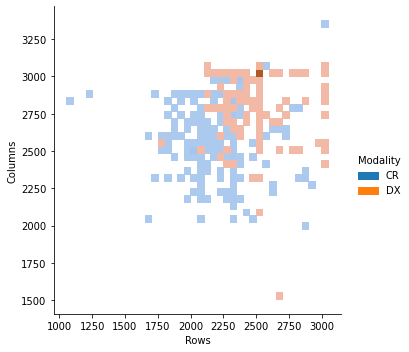

In [6]:
sns.displot(data=meta, x="Rows", y="Columns", bins=40, hue='Modality')

#### Temporal pattern of Images

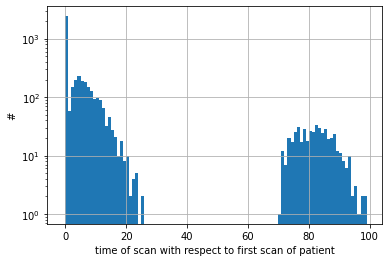

In [7]:
meta = meta.sort_values(by=['Subject', 'StudyDate'])
d = meta.groupby('Subject').StudyDate.transform(lambda x: x-x.iloc[0])

d.hist(bins=np.arange(-1, 100), log=True)
plt.xlabel('time of scan with respect to first scan of patient')
plt.ylabel('#')

after_60 = meta[(d>60)].Subject.nunique()
first_20 = meta[((d>0) & (d<40))].Subject.nunique()

In [8]:
print(f'That is {first_20} patients had a follow-up within the first 20 days and about {after_60} one after 70 days')

That is 873 patients had a follow-up within the first 20 days and about 309 one after 70 days


### Obtain additional Meta Data

In [9]:
add_meta_fields = {
    'ViewPosition': 'View',
    'StudyDescription': 'StudyDescription', 
    'InstitutionName': 'InstitutionName', 
    'ManufacturerModelName': 'ManufacturerModelName',
    'SeriesDescription': 'SeriesDescription',
    'AcquisitionDeviceProcessingDescription': 'AcquisitionDeviceProcessingDescription'
}

In [10]:
extra_data = []
for ix, row in meta.iterrows():
    dcm = pydicom.dcmread(os.path.join(datafolder, 'dicom_clean', row.Filename))
    ex = {k:getattr(dcm, m, None) for m, k in add_meta_fields.items()}
    ex.update({'Filename': row.Filename})
    extra_data.append(ex)

In [11]:
meta = pd.merge(meta, pd.DataFrame(extra_data), on='Filename')
meta.to_csv(os.path.join(datafolder, 'metadata_global_v1_extra.csv'))

## Target Analysis

### Local Score

The multi-region 6-valued Brixia-score was designed and implemented in routine reporting by the Radiology Unit 2 of ASST Spedali Civili di Brescia, and later validated for risk stratification on a large population. According to it, lungs in anteroposterior (AP) or posteroanterior (PA) views, are subdivided into six zones, three for each lung, as shown in the above Figure:

- Upper zones (A and D): above the inferior wall of the aortic arch;
- Middle zones (B and E): below the inferior wall of the aortic arch and above the inferior wall of the right inferior pulmonary vein (i.e., the hilar structures);
- Lower zones (C and F): below the inferior wall of the right inferior pulmonary vein (i.e., the lung bases).

Whenever it is difficult to identify some anatomical landmarks, due to technical reasons (for example bedside CXR in critical patients), it is acceptable to divide each lung into three equal zones. For each zone, a score (ranging from 0 to 3) is assigned, based on the detected lung abnormalities:

- 0: no lung abnormalities;
- 1: interstitial infiltrates;
- 2: interstitial (dominant), and alveolar infiltrates;
- 3: interstitial, and alveolar (dominant) infiltrates.

![title](./BrixiaLocal.png)

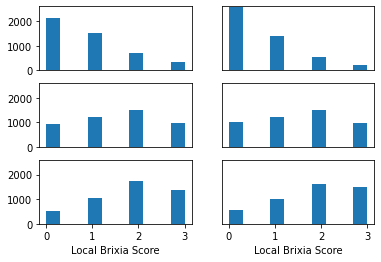

In [12]:
local_score = meta.BrixiaScore.apply(lambda x: [int(i) for i in f'{x:06d}'])
local_score = np.stack(local_score).T

fig, axes = plt.subplots(3, 2)
for ix, scores in enumerate(local_score):
    row, col = ix%3, ix//3
    ax = axes[row, col]
    ax.hist(scores)
    ax.set_ylim(0,2600)
    if col>0: ax.set_yticks([])
    if row != 2:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Local Brixia Score')

### Global Score

Global Score is the sumof al local scores and thus can take values between (0, 18)

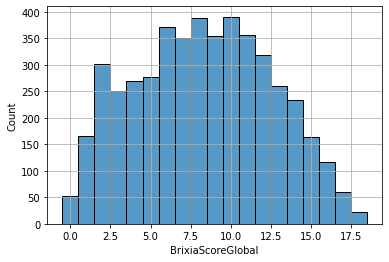

In [13]:
sns.histplot(data = meta, x = 'BrixiaScoreGlobal', bins=np.arange(-0.5,19))
plt.grid()

## Meta-Target Association

In [14]:
marginal = meta.BrixiaScoreGlobal.values
def mwu(y):
    return scipy.stats.mannwhitneyu(marginal, y, alternative='two-sided').pvalue

def stars(y):
    if y > 0.05:
        return ''
    elif y>0.01:
        return '*'
    elif y>0.001:
        return '**'
    elif y>0.0001:
        return '***'
    else:
        return '****'

output_format = {
    ('BrixiaScoreGlobal', 'mean'): '{:.1f}', 
    ('BrixiaScoreGlobal', 'std'): '{:.1f}'
}

In [15]:
m = meta.groupby(['Modality', 'Manufacturer', 'ManufacturerModelName']).agg({'StudyId': 'count', 'BrixiaScoreGlobal' : ['mean', 'std', mwu]})
m[('BrixiaScoreGlobal', 'mwu')] = m[('BrixiaScoreGlobal', 'mwu')].apply(lambda x: stars(x))
m.style.format(output_format)

In [16]:
m = meta.groupby('View').agg({'StudyId': 'count', 'BrixiaScoreGlobal' : ['mean', 'std', mwu]})
m[('BrixiaScoreGlobal', 'mwu')] = m[('BrixiaScoreGlobal', 'mwu')].apply(lambda x: stars(x))
m.style.format(output_format)

In [17]:
m = meta.groupby('Sex').agg({'StudyId': 'count', 'BrixiaScoreGlobal' : ['mean', 'std', mwu]})
m[('BrixiaScoreGlobal', 'mwu')] = m[('BrixiaScoreGlobal', 'mwu')].apply(lambda x: stars(x))
m.style.format(output_format)

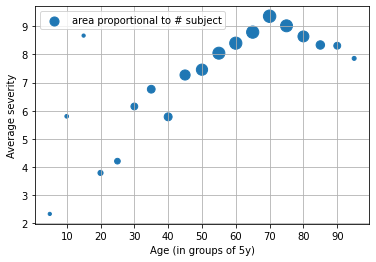

In [18]:
m = meta.groupby('AgeAtStudyDateFiveYear').BrixiaScoreGlobal.agg(['count', 'mean'])
plt.scatter(x=m.index, y=m['mean'], s=6*np.sqrt(m['count']), label='area proportional to # subject')
plt.ylabel('Average severity')
plt.xlabel('Age (in groups of 5y)')
_ = plt.legend()
plt.grid()
x = np.arange(2,19,2)
_ = plt.xticks(x, x*5)

## DataLoader

In [19]:
from torch.utils.data import Dataset

class BrixiaData(Dataset):
    
    def __init__(self,
            meta_csv = 'metadata_global_v1_extra.csv', # file to load
            datapath = '/work/projects/covid19_dv/raw_data/brixia',
            subset = {}, # Define subsetting of data
            include_meta = [], # meta-data to include in targets
            transform = None,
            equalize = 'hist_cv',
            test = False,
            global_score = False
        ):
        
        self.meta_mapping = {
            #'Sex': {'M': -1, 'F': 1},
            #'AP/PA': {'AP': 0, 'PA': 1}
        }
        
               
        self.transform = transform
        self.equalize = equalize
        
        meta_df = pd.read_csv(os.path.join(datapath, meta_csv))
        if test is not None:
            meta_df = meta_df[meta_df.ConsensusTestset == int(test)]
   
        meta_df['Path'] = meta_df.Filename.apply(lambda x: os.path.join(datapath, 'dicom_clean', x))
        
        # Subset the data
        m = meta_df.Path.notnull()
        for k,v in subset.items():
            m &= meta_df[k].isin(v)
        print(f'Removed {sum(np.logical_not(m))} entries')
        meta_df = meta_df[m].reset_index().drop(columns='index')
                
        self.meta_df = meta_df
        self.include_meta = include_meta
        self.global_score = global_score
                    
        
    def __getitem__(self, ix):
                    
        if self.global_score:
            labels = [self.meta_df.loc[ix].BrixiaScoreGlobal]
        else:
            labels = self.meta_df.loc[ix].BrixiaScore
            labels = [int(i) for i in f'{labels:06d}']
        labels += self.meta_df.loc[ix, self.include_meta].to_list()
        labels = np.array(labels).astype('double')
        
        dcm = pydicom.dcmread(os.path.join(datafolder, 'dicom_clean', self.meta_df.loc[ix, 'Filename']))
        image = dcm.pixel_array
        if self.equalize == 'hist_cv':
            image = data_loader.equalize_cv(image, dcm.BitsStored, dcm.PhotometricInterpretation)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels
    
    
    def __len__(self):
        return len(self.meta_df)
    

In [20]:
test = BrixiaData(equalize = 'hist_cv')

Removed 0 entries


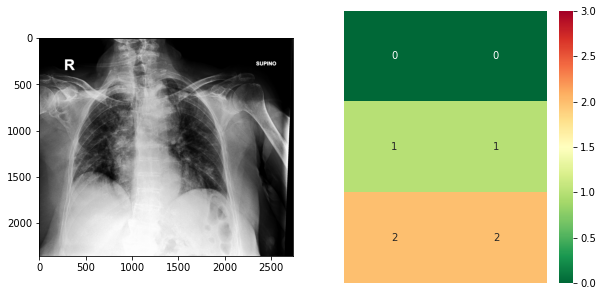

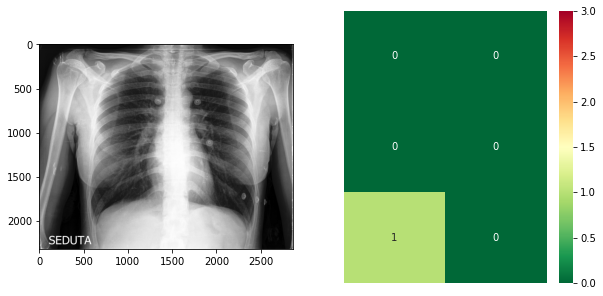

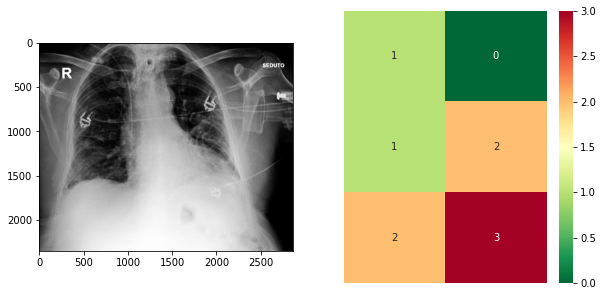

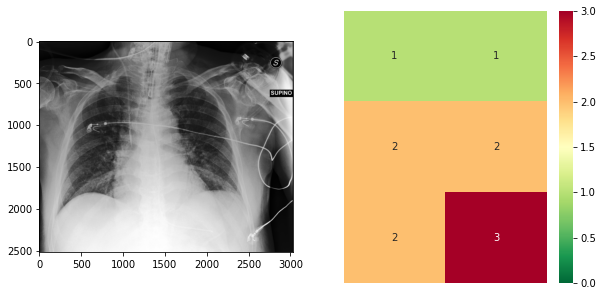

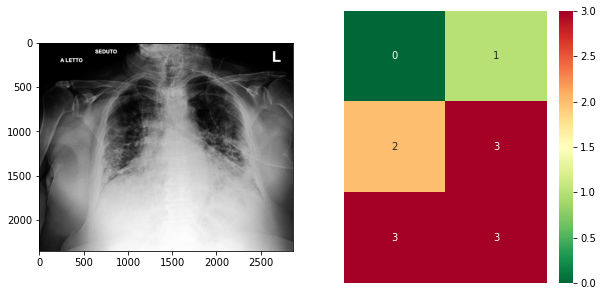

In [21]:
for i in np.random.choice(range(len(test)), 5):

    im, scores = test[i]
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    _ = axes[0].imshow(im)
    sns.heatmap(
        scores.reshape([2,3]).T, 
        vmin=0, vmax=3, cmap=plt.cm.RdYlGn_r, 
        annot=scores.reshape([2,3]).T,
        xticklabels='', yticklabels=''
    )